In [1]:
import os
from tqdm import tqdm
import numpy as np
from collections import Counter
import json
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

train_all_path = '/opt/ml/segmentation/input/data/train_all.json'
train_all = json.load(open(train_all_path, 'r'))

images = train_all['images']
annots = train_all['annotations']
print(train_all.keys())
print(images[0].keys())
print(annots[0].keys())
print(train_all['categories'])

dict_keys(['info', 'licenses', 'images', 'categories', 'annotations'])
dict_keys(['license', 'url', 'file_name', 'height', 'width', 'date_captured', 'id'])
dict_keys(['id', 'image_id', 'category_id', 'segmentation', 'area', 'bbox', 'iscrowd'])
[{'id': 1, 'name': 'General trash', 'supercategory': 'General trash'}, {'id': 2, 'name': 'Paper', 'supercategory': 'Paper'}, {'id': 3, 'name': 'Paper pack', 'supercategory': 'Paper pack'}, {'id': 4, 'name': 'Metal', 'supercategory': 'Metal'}, {'id': 5, 'name': 'Glass', 'supercategory': 'Glass'}, {'id': 6, 'name': 'Plastic', 'supercategory': 'Plastic'}, {'id': 7, 'name': 'Styrofoam', 'supercategory': 'Styrofoam'}, {'id': 8, 'name': 'Plastic bag', 'supercategory': 'Plastic bag'}, {'id': 9, 'name': 'Battery', 'supercategory': 'Battery'}, {'id': 10, 'name': 'Clothing', 'supercategory': 'Clothing'}]


In [2]:
cats = [x['category_id'] for x in annots]
cnt = Counter(cats)

cat_dist = sorted(cnt.items(), key=lambda x: x[0])
xs = [str(x[0]) for x in cat_dist]
ys = [x[1] for x in cat_dist]
print(xs)
print(ys)
# plt.barh(xs, ys)

['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
[2782, 9311, 659, 562, 610, 3090, 1343, 7643, 63, 177]


In [3]:
id2fname = []
images = sorted(images, key=lambda x: x['id'])

# print(images)
for img in images:
    id2fname.append(img['file_name'])

In [4]:
file_annots = {}
for ann in tqdm(annots):
    fname = id2fname[ann['image_id']]

    if fname not in file_annots.keys():
        file_annots[fname] = np.array([0 for _ in range(10)])
    file_annots[fname][ann['category_id']-1] += 1

100%|██████████| 26240/26240 [00:00<00:00, 418616.78it/s]


In [5]:
class Pocket:
    def __init__(self):
        self.ranks = []
        for i in tqdm(range(10)):
            sorted_fname = sorted(file_annots.items(), key=lambda x: x[1][i])
            self.ranks.append(sorted_fname)
    
    def get_file(self, cls: int):
        fannot = self.ranks[cls].pop()
        for i in range(10):
            for idx, item in enumerate(self.ranks[i]):
                if item[0] == fannot[0]:
                    self.ranks[i].pop(idx)
        return fannot

    def is_empty(self):
        assert len(set( [len(x) for x in self.ranks] )) == 1
        return len(self.ranks[0]) == 0

In [6]:
base_dist = ys
def get_inferior(curr_dist):
    diff = (base_dist - curr_dist) / base_dist
    return diff.argmax()

100%|██████████| 10/10 [00:00<00:00, 674.55it/s]


[  541  1835   130   109   120   597   261  1506    12    34 ]
[  556  1850   133   113   122   615   268  1518    13    36 ]
[  539  1821   127   109   118   600   267  1492    12    34 ]
[  585  1937   137   117   127   650   278  1588    13    37 ]
[  561  1868   132   114   123   628   269  1539    13    36 ]
654  654  655  654  654  
3271


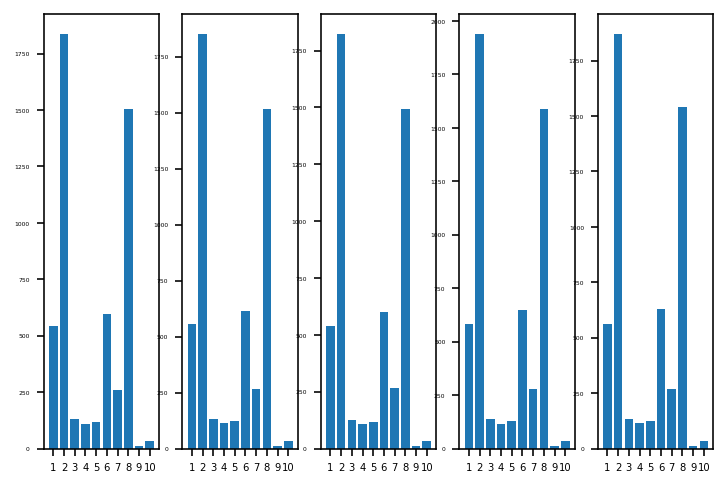

In [7]:
import random
pocket = Pocket()

n_fold = 5
folds = [{'fname': [], 'dist': np.array([0 for _ in range(10)])} for _ in range(n_fold)]

while not pocket.is_empty():
    turns = [x for x in range(n_fold)]
    random.shuffle(turns)
    for _ in range(n_fold):
        i = turns.pop()
        if pocket.is_empty():
            break

        inferior_cls = get_inferior(folds[i]['dist'])
        fname, dist = pocket.get_file(inferior_cls)
        folds[i]['fname'].append(fname)
        folds[i]['dist'] += dist

row, col = 1,n_fold

for i in range(col):
    plt.rcParams['xtick.labelsize'] = 5
    plt.rcParams['ytick.labelsize'] = 3
    plt.subplot(row, col, i+1)
    plt.bar(xs, folds[i]['dist'])

for i in range(n_fold):
    print('[', end='')
    for j in range(10):
        print(f"{folds[i]['dist'][j]: >5}", end=' ')
    print(']')

sum_files = 0
for i in range(n_fold):
    print(len(folds[i]['fname']), end='  ')
    sum_files += len(folds[i]['fname'])

print()
print(sum_files)


In [8]:

imsrc = '/opt/ml/segmentation/input/data'
masrc_tra = '/opt/ml/segmentation/input/data/masks/mode_resampled'
masrc_val = '/opt/ml/segmentation/input/data/masks/origin'

dst = '/opt/ml/segmentation/input/FOLDS/mmseg_5fold_ver3_resam'

if not os.path.isdir(dst):
    for i in range(1, n_fold+1):
        os.makedirs( os.path.join(dst, f'fold{i}', 'images', 'training') )
        os.makedirs( os.path.join(dst, f'fold{i}', 'images', 'validation') )
        os.makedirs( os.path.join(dst, f'fold{i}', 'annotations', 'training') )
        os.makedirs( os.path.join(dst, f'fold{i}', 'annotations', 'validation') )

for f in range(n_fold):
    curr_dst = os.path.join(dst, f'fold{f+1}')
    val = f
    train = [x for x in range(n_fold) if x!=f]

    for fname in tqdm(folds[val]['fname'], desc=f'fold{f+1} valid'):
        # print(f"cp {os.path.join(imsrc, fname)} {os.path.join(dst, f'fold{f+1}', 'images', 'validation', fname.replace('/', '+'))}")
        rep_fname = fname.replace('/', '+')
        os.system(f"cp {os.path.join(imsrc, fname)} {os.path.join(curr_dst, 'images', 'validation', rep_fname)}")
        os.system(f"cp {os.path.join(masrc_val, rep_fname.replace('jpg', 'png'))} {os.path.join(curr_dst, 'annotations', 'validation', rep_fname.replace('jpg', 'png'))}")
    for tr in tqdm(train, desc=f'fold{f+1} train'):
        for fname in folds[tr]['fname']:
            rep_fname = fname.replace('/', '+')
            # print(f"cp {os.path.join(imsrc, fname)} {os.path.join(dst, 'images', 'training', fname)}")
            os.system(f"cp {os.path.join(imsrc, fname)} {os.path.join(curr_dst, 'images', 'training', rep_fname)}")
            os.system(f"cp {os.path.join(masrc_tra, rep_fname.replace('jpg', 'png'))} {os.path.join(curr_dst, 'annotations', 'training', rep_fname.replace('jpg', 'png'))}")

fold5 train: 100%|██████████| 4/4 [02:31<00:00, 37.91s/it]


In [10]:
from glob import glob
for i in range(n_fold):
    print(len(glob(os.path.join(dst, f'fold{i+1}', '**/**/*.jpg'))))

3271
3271
3271
3271
3271
